# **Machine Learning (ML) Methods**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import ast

In [3]:
# Load your data
df = pd.read_csv("lightcast_job_postings.csv")

C:\Users\prabu\AppData\Local\Temp\ipykernel_13776\4181052193.py:2: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lightcast_job_postings.csv")


In [4]:
# Select the relevant columns
cols_to_clean = ['SOC_2021_5_NAME', 'ONET_NAME', 'NAICS_2022_6_NAME']

# Fill missing values with 'Unknown' and strip extra spaces/lowercase
for col in cols_to_clean:
    df[col] = df[col].fillna('Unknown').astype(str).str.strip().str.lower()

# Optionally check unique counts
for col in cols_to_clean:
    print(f"{col}: {df[col].nunique()} unique values")


SOC_2021_5_NAME: 2 unique values
ONET_NAME: 2 unique values
NAICS_2022_6_NAME: 815 unique values


**Clean and Preparing Reference Label Columns**

In [5]:
# Combine cleaned columns into a single string
df['combined_text'] = df['SOC_2021_5_NAME'] + " " + df['ONET_NAME'] + " " + df['NAICS_2022_6_NAME']


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to combined column
tfidf = TfidfVectorizer(max_features=100)  # adjust max_features as needed
X_tfidf = tfidf.fit_transform(df['combined_text']).toarray()

# Convert to DataFrame for merging
df_tfidf = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())


In [7]:
# Create salary column
df['SALARY_AVG'] = df[['SALARY_TO', 'SALARY_FROM']].mean(axis=1)
df['SALARY_AVG'] = df['SALARY_AVG'].fillna(df['SALARY'])

# Fill remaining salary NaNs with 0
df['SALARY_AVG'] = df['SALARY_AVG'].fillna(0)

# Combine TF-IDF + salary into clustering matrix
from sklearn.preprocessing import StandardScaler

X_cluster = pd.concat([df_tfidf, df[['SALARY_AVG']].reset_index(drop=True)], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


**Silhouette to Choose Optimal K**

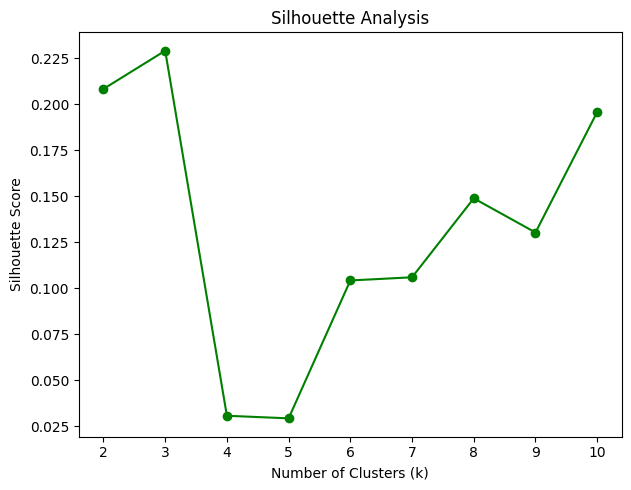

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different k values
sse = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, n_init=3, random_state=42)
    labels = km.fit_predict(X_scaled)

    sse.append(km.inertia_)

    #  Use built-in sample_size to avoid slicing manually
    score = silhouette_score(X_scaled, labels, sample_size=10000, random_state=42)
    silhouette_scores.append(score)

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))


# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


**Fit KMeans and Label the Data with Clusters**

In [19]:
from sklearn.cluster import KMeans

# Re-fit using optimal k = 3
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
df['cluster'] = kmeans_final.fit_predict(X_scaled)


**Visualize: Job Types by Salary (e.g., Boxplot)**

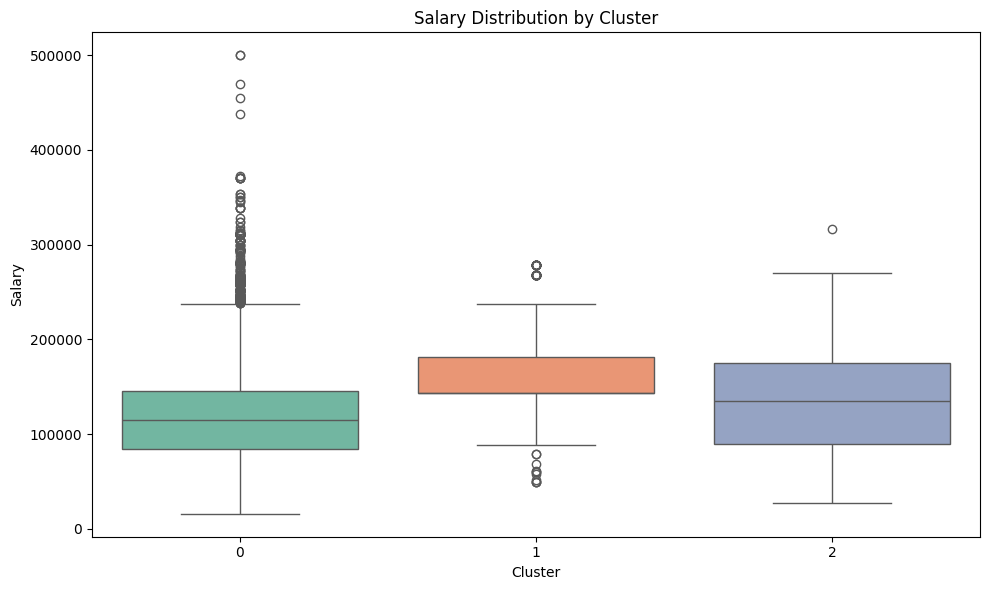

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='SALARY', hue='cluster', palette='Set2', legend=False)
plt.title("Salary Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()


**Visualize: Industry vs. Cluster Heatmap**

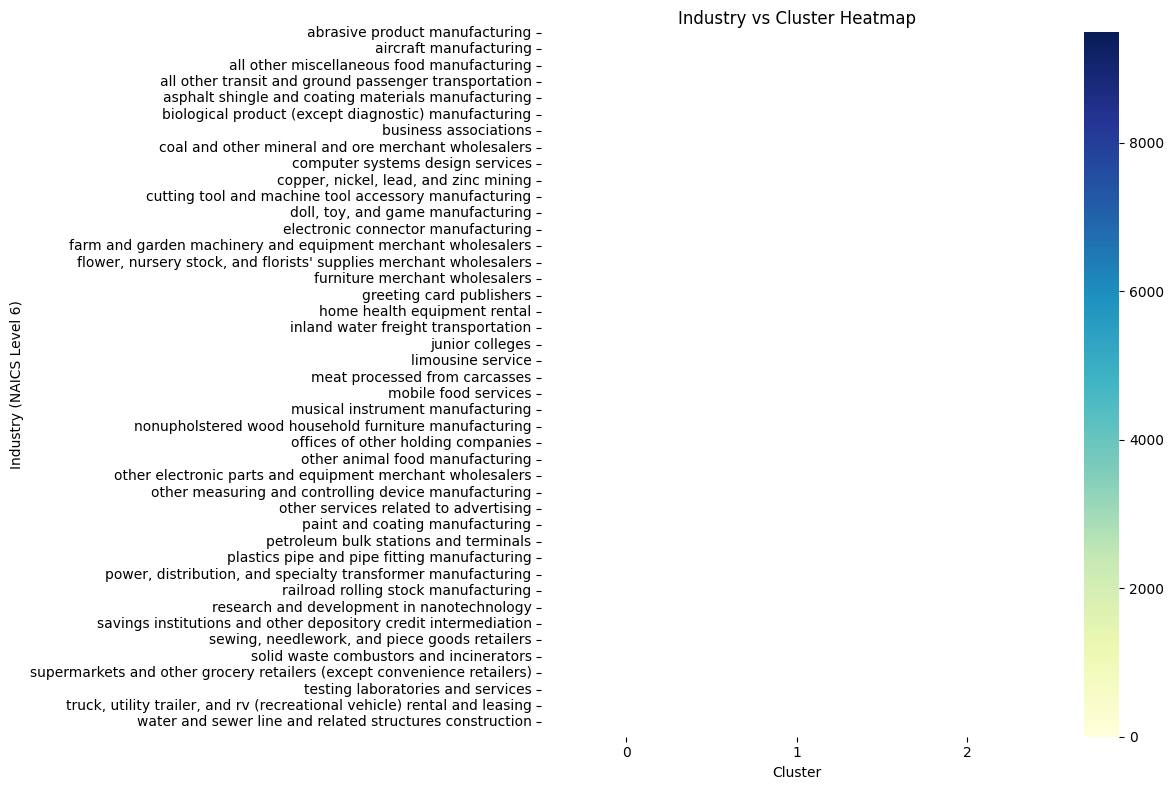

In [21]:
cluster_industry = pd.crosstab(df['NAICS_2022_6_NAME'], df['cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_industry, cmap='YlGnBu', linewidths=0.5)
plt.title("Industry vs Cluster Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Industry (NAICS Level 6)")
plt.tight_layout()
plt.show()


**TF-IDF Based Clustering (Bonus)**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Use job descriptions or skills (cleaned text column)
corpus = df['BODY'].fillna('')  # or use 'TITLE_RAW' or 'SKILLS_NAME'

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(corpus)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
tfidf_labels = kmeans.fit_predict(X_tfidf)

# Add cluster labels
df['TFIDF_Cluster'] = tfidf_labels


**TF-IDF Vectorization**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use 'BODY' as the text source (fallback to 'TITLE_RAW' if BODY is too sparse)
df['BODY'] = df['BODY'].fillna('')

vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=5
)

X_tfidf = vectorizer.fit_transform(df['BODY'])


**KMeans Clustering on TF-IDF**

In [24]:
from sklearn.cluster import KMeans

k_tfidf = 3  # or test different values like before
kmeans_tfidf = KMeans(n_clusters=k_tfidf, random_state=42)
df['TFIDF_Cluster'] = kmeans_tfidf.fit_predict(X_tfidf)


**Top Terms per Cluster**

In [25]:
import numpy as np

# Get feature names
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]

# Print top terms for each cluster
for i in range(k_tfidf):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")


Cluster 0 top terms: oracle, experience, business, job, work, management, enterprise, architecture, skills, cloud
Cluster 1 top terms: data, experience, business, work, analytics, job, analyst, analysis, skills, data analyst
Cluster 2 top terms: sap, experience, business, job, consultant, hana, experience sap, functional, accenture, sd


**Visualize TF-IDF Clusters**

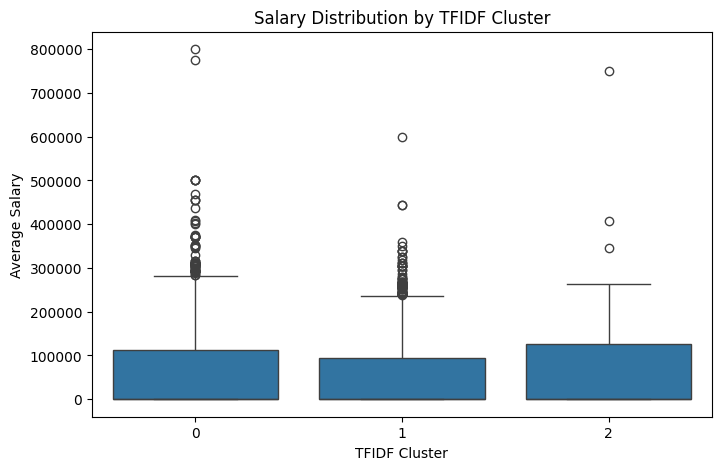

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot salary by TFIDF cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='TFIDF_Cluster', y='SALARY_AVG')
plt.title('Salary Distribution by TFIDF Cluster')
plt.xlabel('TFIDF Cluster')
plt.ylabel('Average Salary')
plt.show()


**Industry Distribution in TF-IDF Clusters**

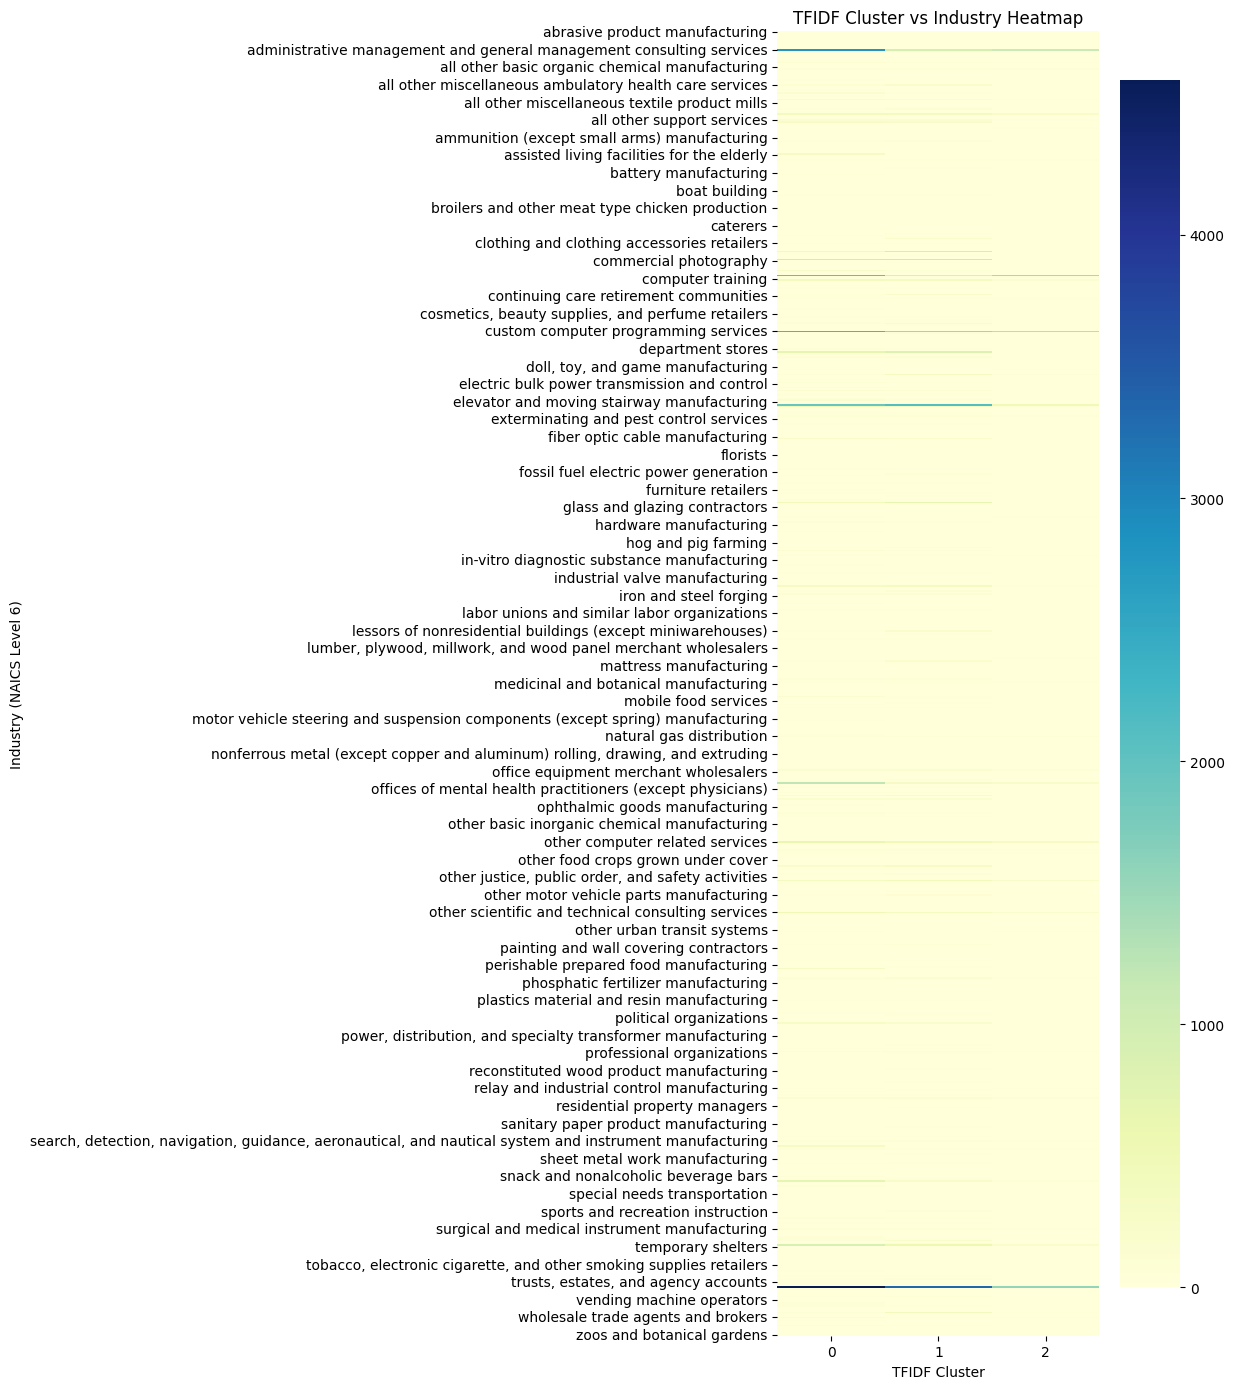

In [27]:
industry_cluster = df.groupby(['TFIDF_Cluster', 'NAICS_2022_6_NAME']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 14))
sns.heatmap(industry_cluster.T, cmap='YlGnBu')
plt.title('TFIDF Cluster vs Industry Heatmap')
plt.xlabel('TFIDF Cluster')
plt.ylabel('Industry (NAICS Level 6)')
plt.tight_layout()
plt.show()
